In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

In [2]:
fracs_count = 4  # количество трещин
K_c = 1e6  # Па*м^(1/2) трещиностойкость

In [3]:
# параметры задачи в символьном виде

Q_0, p_0 = symbols('Q0 p0', real=True)  # суммарный расход на забое и забойное давление

Q = np.array(symbols(f'Q1:{fracs_count+1}', real=True))  # расходы на каждой из трещин
x_f = np.array(symbols(f'x_f1:{fracs_count+1}', real=True))  # полудлина каждой из трещин
E = np.array(symbols(f'E1:{fracs_count+1}', real=True))  # модуль плоской деформации каждой из трещин
h = np.array(symbols(f'h1:{fracs_count+1}', real=True))  # мощность продуктивной зоны для каждой из трещин
K, n, phi = symbols('K n phi', real=True)  # реологические параметры жидкости и геометрический параметр трещины
k_e = symbols('k_e', real=True)  # проницаемость пласта
p_e = symbols('p_e', real=True)  # пластовое давление
phi_e = symbols('phi_e', real=True)  # пористость пласта
c_t = symbols('c_t', real=True)  # общая сжимаемость
t = symbols('t', real=True)  # время
p_frac_net = np.array(symbols(f'p_frac_net1:{fracs_count+1}', real=True))  # чистые давления на каждой из трещин

n_p = np.array(symbols(f'n_p1:{fracs_count+1}', real=True))  # количество перфораций на каждой из трещин
d_p = np.array(symbols(f'd_p1:{fracs_count+1}', real=True))  # диаметр перфораций на каждой из трещин
C_d = np.array(symbols(f'C_d1:{fracs_count+1}', real=True))  # коэффициент эрозии на каждой из трещин
rho_s = symbols('rho_s', real=True)  # средняя плотность смеси

R = np.array(symbols(f'R1:{fracs_count+1}', real=True))  # радиус участков трубы к каждой из трещин
L = np.array(symbols(f'L1:{fracs_count+1}', real=True))  # длина участков трубы, ведущих к каждой из трещин

u_m = np.array(symbols(f'u_m1:{fracs_count+1}', real=True))  # средняя скорость на рассматриваемом участке к каждой из трещин
sigma_min = symbols(f'sigma_min1:{fracs_count+1}')  # давление закрытия для каждой из трещин

# для пошагового использования формулы Кёнинга
dQ = np.array(symbols(f'dQ1:{fracs_count+1}', real=True))  # изменения расходов на каждой из трещин
dp_f = np.array(symbols(f'dp_net1:{fracs_count+1}', real=True))  # изменения давлений на каждой из трещин
dt = symbols('dt', real=True)  # шаг по времени

In [4]:
# чистое давление в трещинах
def p_net():
    V = h * (2 * x_f) * K_c * (S.Pi*h)**(1/2) / E
    a = (((n + 3) * (2 * n + 1)**n * K * E**(2*n+2)) / \
         (S.Pi * 2**(2 * n) * n**n * phi**n * h**(3 * n + 3))) ** (1 / (2 * n + 3))
    p_net = a * Q**(n/(2*n+3)) * V**(1/(2*n+3))  # давление на каждой из трещин
    return p_net

# падение давления на перфорациях
def delta_p_perf():
    # падение давления на перфорациях на каждой из трещин
    delta_p_perf = 8 * rho_s / (S.Pi**2 * C_d**2 * n_p**2 * d_p**4) * Q * abs(Q)
    return delta_p_perf

# падение давления на трение в трубе
def delta_p_fric():
    for i, _ in enumerate(u_m):
        u_m[i] = (Q_0 - sum([Q[j] for j in range(i)])) / (S.Pi * R[i]**2)
    delta_p_fric = 8 * (K / R) * (u_m / R) * L  # падение давления на трение в трубе для каждой из трещин
    return delta_p_fric

In [5]:
def kirchhoff_solver(parameter_values):
    all_eqns = np.array([])  # массив со всеми уравнениями законов Кирхгофа
    
    # добавляем левую часть уравнений второго закона Кирхгофа в массив all_eqns
    for i in range(fracs_count):
        all_eqns = np.append(all_eqns, p_0 - sigma_min[i] - p_net()[i] - delta_p_perf()[i] - sum([delta_p_fric()[j] for j in range(i+1)]))

    # добавляем левую часть уравнения первого закона Кирхгофа в массив all_eqns
    all_eqns = np.append(all_eqns, Q_0 - sum(Q))
    
    # матрица Якоби
    J = np.zeros(shape=(fracs_count+1, fracs_count+1), dtype=object)
    for i, _ in enumerate(all_eqns):
        for j, _ in enumerate(Q):
            J[i, j] = diff(all_eqns[i], Q[j])
        J[i, -1] = diff(all_eqns[i], p_0)
    J_sym = Matrix(J)
    #display(J_sym)

    # начальные приближения числовых значений неизвестных параметров задачи
    solution_values = {}
    for i in range(fracs_count):
        solution_values[Q[i]] = N(Q_0.subs(parameter_values)/fracs_count)  # расходы на каждой из трещин (начальное приближение)
    solution_values[p_0] = N(sigma_min[0].subs(parameter_values))  # забойное давление (начальное приближение)

    # вектор решения
    solution_vector = np.array(list(N(Matrix(Q).subs(solution_values)))+[N(p_0.subs(solution_values))], dtype='float64').reshape(fracs_count+1,1)
    # предыдущий вектор решения
    last_solution_vector = solution_vector - 100

    # реализация метода Ньютона
    while np.linalg.norm(solution_vector - last_solution_vector) > 1e-4:
        # обновляем предыдущий вектор решения
        last_solution_vector = solution_vector.copy()
        # матрица Якоби
        #print(N(J_sym.subs({**parameter_values, **solution_values})))
        J = np.array(N(J_sym.subs({**parameter_values, **solution_values})), dtype='float64')
        # вектор остатков
        residual_vector = np.array(N(Matrix(all_eqns).subs({**parameter_values, **solution_values})), dtype='float64')
        # новый вектор решения
        solution_vector -= np.matmul(np.linalg.inv(J), residual_vector)
        for i, val in enumerate(solution_vector):
            if val < 0:
                solution_vector[i] = 1e-21
        # обновление значений текущего вектора решения в словаре solution_values
        for i in range(fracs_count):
            solution_values[Q[i]] = solution_vector.reshape(fracs_count+1,)[i]
        solution_values[p_0] = solution_vector.reshape(fracs_count+1,)[-1]
    return solution_values

In [6]:
# проверяю работу решателя Кирхгофа

parameter_values = {
    Q_0: 800 / 86400,  # расход на забое, м^3/с
    K: 0.001,  # первый реологический параметр жидкости (вязкость воды), Па*с
    n: 1,  # второй реологический параметр жидкости (ньютоновская жидкость - вода)
    phi: 0.3,  # безразмерный геометрический параметр трещины
    rho_s: 1000,  # плотность жидкости (воды), кг/м^3
    k_e: 1e-15,  # проницаемость, м^2
    phi_e: 0.2,  # пористость
    c_t: 2.2e-9,  # Па^(-1), общая сжимаемость
    p_e: 0.9e7  # Па, пластовое давление
}

for i in range(fracs_count):
    parameter_values[x_f[i]] = 1 # полудлина трещины, м
    parameter_values[E[i]] = 1e10  # модули плоской деформации трещин, Па
    parameter_values[h[i]] = 2  # мощности продуктивной зоны, м
    parameter_values[n_p[i]] = 32  # количества перфораций
    parameter_values[d_p[i]] = 0.02  # диаметры перфораций, м
    parameter_values[C_d[i]] = 0.7  # безразмерные коэффициенты эррозии
    parameter_values[R[i]] = 0.08  # радиусы участков трубы между i-ой и (i-1)-ой трещинами, м
    parameter_values[L[i]] = 100  # длины участков трубы между i-ой и (i-1)-ой трещинами, м
    parameter_values[sigma_min[i]] = 1e7  # давления закрытия трещин, Па

parameter_values[n_p[1]] = 2
parameter_values[d_p[1]] = 0.01
parameter_values[n_p[2]] = 1
parameter_values[d_p[2]] = 0.01
#parameter_values[n_p[3]] = 4
parameter_values[d_p[3]] = 0.01
#parameter_values[E[2]] = 2e10
#parameter_values[sigma_min[3]] = 1.02e7
solution_values = kirchhoff_solver(parameter_values)
display(solution_values)

{Q1: 0.0032078044063851407,
 Q2: 0.0017452989366348987,
 Q3: 0.0011219098178611405,
 Q4: 0.0031842460983780795,
 p0: 11098675.447315441}

In [7]:
# формула Кёнинга
def koning_formula():
    kappa = k_e / (phi_e * K * c_t)
    x_frac = Q * K * ((S.Pi * kappa * t)**(1/2)) / (2 * S.Pi * k_e * h * (p_frac_net + sigma_min - p_e))
    return x_frac

# полная производная по времени формулы Кёнинга
def koning_formula_derivative():
    kappa = k_e / (phi_e * K * c_t)
    dx_frac = K * ((S.Pi * kappa * t)**(1/2)) * dQ / (2 * S.Pi * k_e * h * (p_frac_net + sigma_min - p_e)) + \
            Q * K * ((S.Pi * kappa / t)**(1/2)) * dt / (4 * S.Pi * k_e * h * (p_frac_net + sigma_min - p_e)) - \
            Q * K * ((S.Pi * kappa * t)**(1/2)) * dp_f / (2 * S.Pi * k_e * h * (p_frac_net + sigma_min - p_e)**2)
    return dx_frac

In [8]:
koning_formula()

array([K*Q1*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h1*k_e*(-p_e + p_frac_net1 + sigma_min1)),
       K*Q2*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h2*k_e*(-p_e + p_frac_net2 + sigma_min2)),
       K*Q3*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h3*k_e*(-p_e + p_frac_net3 + sigma_min3)),
       K*Q4*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h4*k_e*(-p_e + p_frac_net4 + sigma_min4))],
      dtype=object)

In [9]:
koning_formula_derivative()

array([-K*Q1*dp_net1*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h1*k_e*(-p_e + p_frac_net1 + sigma_min1)**2) + K*Q1*dt*(k_e/(K*c_t*phi_e*t))**0.5/(4*pi**0.5*h1*k_e*(-p_e + p_frac_net1 + sigma_min1)) + K*dQ1*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h1*k_e*(-p_e + p_frac_net1 + sigma_min1)),
       -K*Q2*dp_net2*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h2*k_e*(-p_e + p_frac_net2 + sigma_min2)**2) + K*Q2*dt*(k_e/(K*c_t*phi_e*t))**0.5/(4*pi**0.5*h2*k_e*(-p_e + p_frac_net2 + sigma_min2)) + K*dQ2*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h2*k_e*(-p_e + p_frac_net2 + sigma_min2)),
       -K*Q3*dp_net3*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h3*k_e*(-p_e + p_frac_net3 + sigma_min3)**2) + K*Q3*dt*(k_e/(K*c_t*phi_e*t))**0.5/(4*pi**0.5*h3*k_e*(-p_e + p_frac_net3 + sigma_min3)) + K*dQ3*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h3*k_e*(-p_e + p_frac_net3 + sigma_min3)),
       -K*Q4*dp_net4*(k_e*t/(K*c_t*phi_e))**0.5/(2*pi**0.5*h4*k_e*(-p_e + p_frac_net4 + sigma_min4)**2) + K*Q4*dt*(k_e/(K*c_t*phi_e*t))**0.5/(4*pi**0.5

In [10]:
time_mesh = np.concatenate([np.array([0.1]), np.arange(0.1, 3, 0.02)])
for i, val in enumerate(time_mesh[1:]):
    time_mesh[i+1] += time_mesh[i]
time_mesh = time_mesh[:30]
#time_mesh = np.arange(0.1,10.5,0.1)
time_mesh

array([ 0.1 ,  0.2 ,  0.32,  0.46,  0.62,  0.8 ,  1.  ,  1.22,  1.46,
        1.72,  2.  ,  2.3 ,  2.62,  2.96,  3.32,  3.7 ,  4.1 ,  4.52,
        4.96,  5.42,  5.9 ,  6.4 ,  6.92,  7.46,  8.02,  8.6 ,  9.2 ,
        9.82, 10.46, 11.12])

In [11]:
display_output = False

for_koning_values = {}

for_koning_values[t] = time_mesh[0]
for_koning_values[dt] = time_mesh[1] - time_mesh[0]

times = []  # список времён, для которых проводился расчёт
p_0_values = []  # список забойных давлений
p_net_values = []  # список чистых давлений в трещинах
Q_values = []  # список дебитов на трещинах
x_frac_values = []  # список полудлин трещин
p_net_prop_values = []  # список минимальных чистых давлений в трещине для её распространения

for t_ind, t_value in enumerate(tqdm(time_mesh[:-1])):

    solution_values = kirchhoff_solver(parameter_values)
    
    times.append(for_koning_values[t])

    p_0_value = solution_values.get(p_0)
    p_0_values.append(p_0_value)

    Q_value = [solution_values[symbols('Q'+str(i), real=True)] for i in range(1, fracs_count+1)]
    Q_values.append(Q_value)

    p_net_value = [N(i.subs({**parameter_values, **solution_values})) for i in p_net()]
    p_net_values.append(p_net_value)

    for i in range(fracs_count):
        for_koning_values[p_frac_net[i]] = p_net_value[i]
    
    p_net_prop = K_c / (S.Pi * x_f)**(1/2)
    p_net_prop_value = [N(i.subs({**parameter_values})) for i in p_net_prop]
    p_net_prop_values.append(p_net_prop_value)
    
    if t_value == time_mesh[0]:
        x_frac = [N(i.subs({**parameter_values, **solution_values, **for_koning_values})) for i in koning_formula()]
    else:
        for i in range(fracs_count):
            for_koning_values[dQ[i]] = Q_values[-1][i] - Q_values[-2][i]
            for_koning_values[dp_f[i]] = p_net_values[-1][i] - p_net_values[-2][i]
        dx_frac = [N(i.subs({**parameter_values, **solution_values, **for_koning_values})) for i in koning_formula_derivative()]
        dx_frac = [el if el >= 0 else 0 for el in dx_frac]
        for i in range(fracs_count):
            if for_koning_values[p_frac_net[i]] < p_net_prop_values[-1][i]:
                dx_frac[i] = 0
        x_frac = np.array(x_frac_values[-1]) + np.array(dx_frac)
    x_frac_values.append(x_frac)
    
    #print(x_frac)

    for i in range(fracs_count):
        parameter_values[x_f[i]] = x_frac[i]
    
    #print(p_net_prop_value)
    #print(p_net_value)
    for_koning_values[t] = time_mesh[t_ind+1]
    for_koning_values[dt] = time_mesh[t_ind+1] - time_mesh[t_ind]
    

    #if for_koning_values[t] >= 100:
    #    parameter_values[d_p[1]] = 0.005

    if display_output:
        print(x_frac, 'метров')
        print(for_koning_values[t], ' сек')

100%|██████████| 29/29 [01:47<00:00,  3.71s/it]


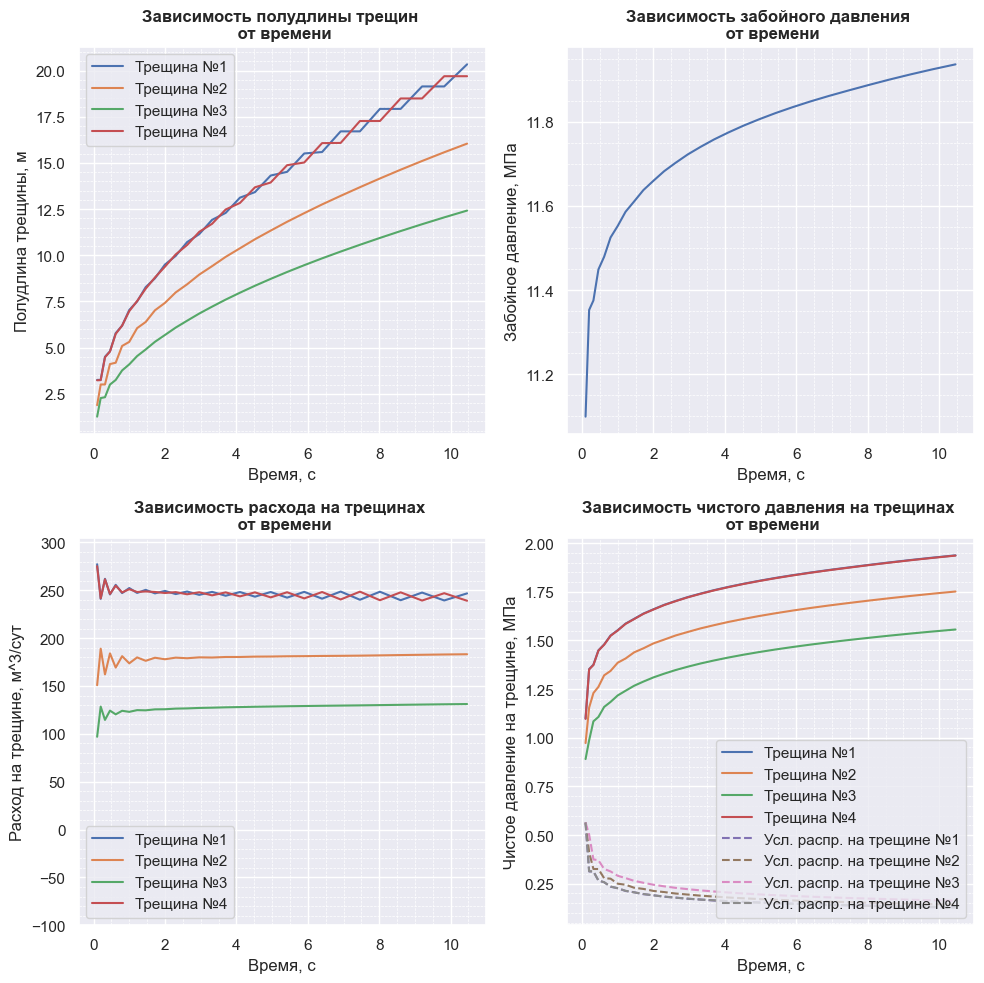

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

axs[0,0].plot(times, x_frac_values, label=[f'Трещина №{i+1}' for i in range(fracs_count)])
axs[0,0].set_xlabel('Время, с')
axs[0,0].set_ylabel('Полудлина трещины, м')
axs[0,0].set_title('Зависимость полудлины трещин \n от времени', weight='bold')
axs[0,0].legend()
axs[0,0].minorticks_on()
axs[0,0].grid(which='minor', linestyle='--', linewidth=0.5)

axs[0,1].plot(times, np.array(p_0_values)/1e6)
axs[0,1].set_xlabel('Время, с')
axs[0,1].set_ylabel('Забойное давление, МПа')
axs[0,1].set_title('Зависимость забойного давления \n от времени', weight='bold')
axs[0,1].minorticks_on()
axs[0,1].grid(which='minor', linestyle='--', linewidth=0.5)

axs[1,0].plot(times, np.array(Q_values)*86400, label=[f'Трещина №{i+1}' for i in range(fracs_count)])
axs[1,0].set_ylim([-100, 1.1*max(np.array(Q_values).flatten())*86400])
axs[1,0].set_xlabel('Время, с')
axs[1,0].set_ylabel('Расход на трещине, м^3/сут')
axs[1,0].set_title('Зависимость расхода на трещинах \n от времени', weight='bold')
axs[1,0].legend()
axs[1,0].minorticks_on()
axs[1,0].grid(which='minor', linestyle='--', linewidth=0.5)

axs[1,1].plot(times, np.array(p_net_values)/1e6, label=[f'Трещина №{i+1}' for i in range(fracs_count)])
axs[1,1].plot(times, np.array(p_net_prop_values)/1e6, linestyle='--',
              label=[f'Усл. распр. на трещине №{i+1}' for i in range(fracs_count)])
axs[1,1].set_xlabel('Время, с')
axs[1,1].set_ylabel('Чистое давление на трещине, МПа')
axs[1,1].set_title('Зависимость чистого давления на трещинах \n от времени', weight='bold')
axs[1,1].legend(loc="lower right")
axs[1,1].minorticks_on()
axs[1,1].grid(which='minor', linestyle='--', linewidth=0.5)

fig.tight_layout()